In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_TRACING_V2_ENABLED = os.getenv("LANGCHAIN_TRACING_V2_ENABLED")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")


In [2]:
from unstructured.partition.pdf import partition_pdf

output_path = "./content/"
file_path= output_path + 'build a llm book-25-93.pdf'

chunks = partition_pdf(
    filename=file_path,
    pdf_infer_table_structure=True,
    strategy="hi_res",
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=20000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000,
)

c:\Users\infin\OneDrive\Desktop\make_it_easy\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [5]:
chunks[3].metadata.orig_elements

In [7]:
elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
print(f"Number of images: {len(chunk_images)}")
chunk_images[0].to_dict()

Number of images: 1


{'type': 'Image',
 'element_id': '07ad9c38-6ad2-4586-bd4f-88b221273d00',
 'text': 'An LLM is pretrained on unlabeled \\ data. + Internet texts * Books * Wikipedia + Research articles Raw, unlabeled text (trillions of words) A pretrained LLM can be further trained on a labeled dataset to obtain a fine-tuned LLM for specific tasks. The LLM has a few x~_/ basic capabilities + Text (a \\ after pretraining. + Few-shot (a * Classification + Summarization + Translation + Personal assistant , S Fine-tuned LLM = Labeled dataset',
 'metadata': {'coordinates': {'points': ((np.float64(214.42153773243555),
     np.float64(200.00003166666494)),
    (np.float64(214.42153773243555), np.float64(838.6687450554674)),
    (np.float64(1499.9997508333413), np.float64(838.6687450554674)),
    (np.float64(1499.9997508333413), np.float64(200.00003166666494))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-05-03T11:46:48',
  'filetype': 'PPM',
  'languag

In [8]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [9]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

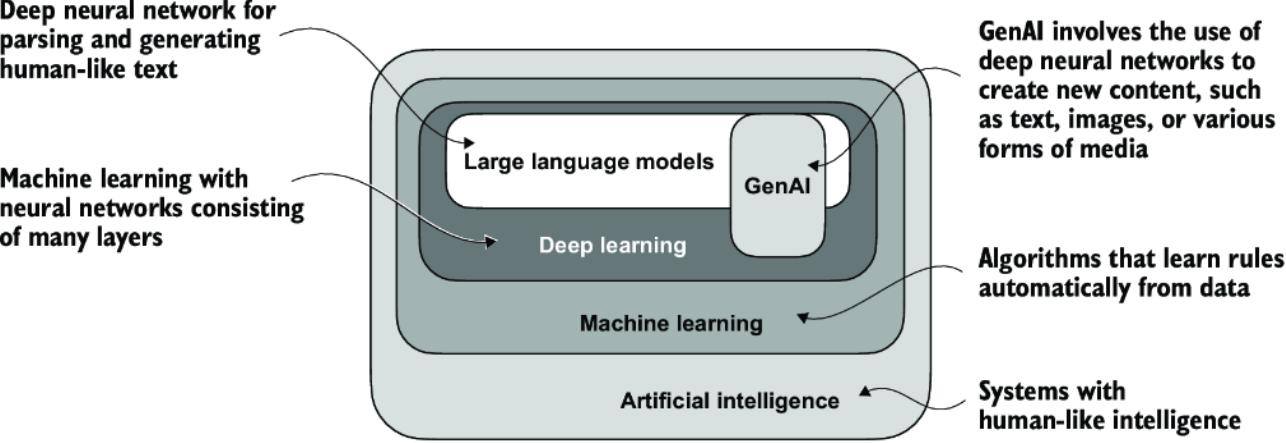

In [11]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

In [12]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [13]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [19]:
import time
import re
from openai import RateLimitError

def safe_batch_summarize(chain, inputs, config, max_retries=5):
    for attempt in range(max_retries):
        try:
            return chain.batch(inputs, config)
        except RateLimitError as e:
            # Extract wait time from the error message
            message = str(e)
            match = re.search(r'try again in ([\d\.]+)s', message)
            wait_time = float(match.group(1)) if match else 15
            print(f"Rate limit hit. Retrying in {wait_time:.2f} seconds...")
            time.sleep(wait_time)
    raise Exception("Rate limit error: max retries exceeded.")


In [20]:
text_summaries = safe_batch_summarize(summarize_chain, texts, {"max_concurrency": 1})

In [21]:
text_summaries

['This chapter covers the fundamental concepts of large language models (LLMs), their transformer architecture, and a plan for building an LLM from scratch. LLMs have revolutionized natural language processing, enabling complex understanding, generation, and interpretation of human language. Their capabilities are attributed to advancements in deep learning and large-scale training on vast text data, allowing them to capture deeper contextual information and subtleties of human language.',
 'Large Language Models (LLMs) are deep neural networks trained on massive text data to understand, generate, and respond to human-like text. They utilize the transformer architecture, allowing selective attention to input parts, and are a form of generative artificial intelligence. LLMs are a specific application of deep learning techniques, using multilayer neural networks to process and generate human-like text.',
 'Spam is classified using both traditional machine learning and deep learning, the 

In [23]:
# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = safe_batch_summarize(summarize_chain,tables_html, {"max_concurrency": 1})

In [24]:
table_summaries

[]

In [28]:
%pip install -U langchain-google-genai

Note: you may need to restart the kernel to use updated packages.Collecting langchain-google-genai
     ---------------------------------------- 0.0/44.3 kB ? eta -:--:--
     ---------------------------------------- 44.3/44.3 kB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
     --------- ------------------------------ 0.3/1.4 MB 10.2 MB/s eta 0:00:01
     ---------------------------------- ----- 1.2/1.4 MB 12.6 MB/s eta 0:00:01
     ---------------------------------------- 1.4/1.4 MB 12.4 MB/s eta 0:00:00




[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import time
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

# Define prompt
prompt_template = """Describe the image in detail. For context,
the image is part of a research paper explaining the transformers
architecture. Be specific about graphs, such as bar plots."""

messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

# Gemini setup (ensure GEMINI_API_KEY is set in your environment)
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    google_api_key=GEMINI_API_KEY
)

chain = prompt | llm | StrOutputParser()

# Replace 'images' with your actual list of base64-encoded image strings
image_summaries = []

for idx, image in enumerate(images):
    try:
        print(f"Processing image {idx + 1}/{len(images)}...")
        result = chain.invoke({"image": image})
        image_summaries.append(result)
        time.sleep(5)  # Adjust based on observed limits
    except Exception as e:
        print(f"Error processing image {idx + 1}: {e}")
        image_summaries.append("Error or rate-limited")



Processing image 1/32...
Processing image 2/32...
Processing image 3/32...
Processing image 4/32...
Processing image 5/32...
Processing image 6/32...
Processing image 7/32...
Processing image 8/32...
Processing image 9/32...
Processing image 10/32...
Processing image 11/32...
Processing image 12/32...
Processing image 13/32...
Processing image 14/32...
Processing image 15/32...
Processing image 16/32...
Processing image 17/32...
Processing image 18/32...
Processing image 19/32...
Processing image 20/32...
Processing image 21/32...
Processing image 22/32...
Processing image 23/32...
Processing image 24/32...
Processing image 25/32...
Processing image 26/32...
Processing image 27/32...
Processing image 28/32...
Processing image 29/32...
Processing image 30/32...
Processing image 31/32...
Processing image 32/32...


In [42]:
image_summaries

['The image is a nested diagram illustrating the hierarchical relationship between different concepts in artificial intelligence (AI), specifically focusing on the role of deep learning and large language models in generative AI (GenAI).\n\nThe diagram uses concentric rounded rectangles to represent the different levels of abstraction. The outermost rectangle is labeled "Artificial Intelligence" and is defined as "Systems with human-like intelligence".  The next layer inward is "Machine learning", described as "Algorithms that learn rules automatically from data". The next layer is "Deep learning", defined as "Machine learning with neural networks consisting of many layers".  The innermost layer is split into two sections: a larger section labeled "Large language models" and a smaller, overlapping section labeled "GenAI".  \n\nArrows connect the layers and sections, indicating the hierarchical relationships.  For example, an arrow connects "Deep learning" to "Machine learning," showing

In [45]:
print(image_summaries[2])

The image is a flowchart illustrating the training process of a Large Language Model (LLM). 


The flowchart begins with a box representing raw, unlabeled text data consisting of internet texts, books, Wikipedia articles, and research papers (trillions of words). An arrow labeled "Train" points from this box to a house-shaped icon representing the pretraining phase, resulting in a "Pretrained LLM (foundation model)". 


A second arrow, also labeled "Train," leads from the pretrained LLM to another box. This box lists the basic capabilities gained after the pretraining: text completion and few-shot capabilities. A curved arrow connects this box to a text indicating that the LLM possesses a few basic capabilities after pretraining.


The flowchart then shows a separate path where the pretrained LLM is further trained on a labeled dataset (represented by a database icon). This fine-tuning step produces a "Fine-tuned LLM," capable of performing specific tasks such as classification, summar

In [52]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
embeddings = GoogleGenerativeAIEmbeddings(google_api_key=GEMINI_API_KEY,model="models/embedding-001")
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embeddings)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [55]:
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]})
    for i, summary in enumerate(text_summaries)
    if summary.strip()  # Ensures summary is not empty or whitespace
]
retriever.vectorstore.add_documents(summary_texts)

# Ensure same filtering for original documents
retriever.docstore.mset([
    (doc_ids[i], texts[i])
    for i, summary in enumerate(text_summaries)
    if summary.strip()
])


In [57]:
# Generate embeddings manually to verify they're valid
valid_docs = []
valid_ids = []

for i, summary in enumerate(table_summaries):
    if summary.strip():
        try:
            embedding = embeddings.embed_query(summary)  # force embedding to catch errors
            if embedding:  # non-empty list
                doc = Document(page_content=summary, metadata={id_key: table_ids[i]})
                valid_docs.append(doc)
                valid_ids.append(table_ids[i])
        except Exception as e:
            print(f"Embedding failed for index {i}: {e}")

# Add only valid ones
if valid_docs:
    retriever.vectorstore.add_documents(valid_docs)
    retriever.docstore.mset(list(zip(valid_ids, [tables[i] for i in range(len(table_ids)) if table_ids[i] in valid_ids])))
else:
    print("No valid table summaries to add.")


No valid table summaries to add.


In [60]:
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]})
    for i, summary in enumerate(image_summaries)
    if summary.strip()
]
retriever.vectorstore.add_documents(summary_img)

retriever.docstore.mset([
    (img_ids[i], images[i])
    for i, summary in enumerate(image_summaries)
    if summary.strip()
])


In [61]:
# Retrieve
docs = retriever.invoke(
    "what is the name of first chapter and its all sub topics?"
)

In [62]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

1 Understanding large language models

This chapter covers

High-level explanations of the fundamental concepts behind large language models (LLMs)

Insights into the transformer architecture from which LLMs are derived

A plan for building an LLM from scratch

Large language models (LLMs), such as those offered in OpenAI’s ChatGPT, are deep neural network models that have been developed over the past few years. They ushered in a new era for natural language processing (NLP). Before the advent of LLMs, traditional methods excelled at categorization tasks such as email spam classification and straightforward pattern recognition that could be captured with handcrafted rules or simpler models. However, they typically underperformed in language tasks that demanded complex understanding and generation abilities, such as parsing detailed instructions, conducting contextual analysis, and creating coherent and contextually appropriate original text. For example, previous generations of languag

In [64]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=GEMINI_API_KEY)
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=GEMINI_API_KEY)
        | StrOutputParser()
    )
)

In [65]:
response = chain.invoke(
    "What is LLM?"
)

print(response)

Based on the provided text, an LLM (Large Language Model) is a neural network designed to understand, generate, and respond to human-like text.  These models are deep neural networks trained on massive amounts of text data, sometimes encompassing large portions of publicly available internet text.  The "large" refers to both the model's size (tens or hundreds of billions of parameters) and the immense dataset used for training.  LLMs utilize a transformer architecture, allowing selective attention to different input parts for prediction.  They are a form of generative AI (GenAI) because of their text generation capabilities.


Response: Based on the provided text, the transformer architecture consists of two main submodules: an encoder and a decoder.  The encoder processes the input text and creates embedding vectors (numerical representations) that capture contextual information. The decoder then uses these vectors to generate the output text.  Both the encoder and decoder utilize a self-attention mechanism (explained further in Chapter 3).  Later variants like BERT (using only the encoder) and GPT (using only the decoder) adapt this architecture for different tasks.


Context:
1.4 Introducing the transformer architecture

Most modern LLMs rely on the transformer architecture, which is a deep neural network architecture introduced in the 2017 paper “Attention Is All You Need” (https://arxiv.org/abs/1706.03762). To understand LLMs, we must understand the original transformer, which was developed for machine translation, translating English texts

to German and French. A simplified version of the transformer 

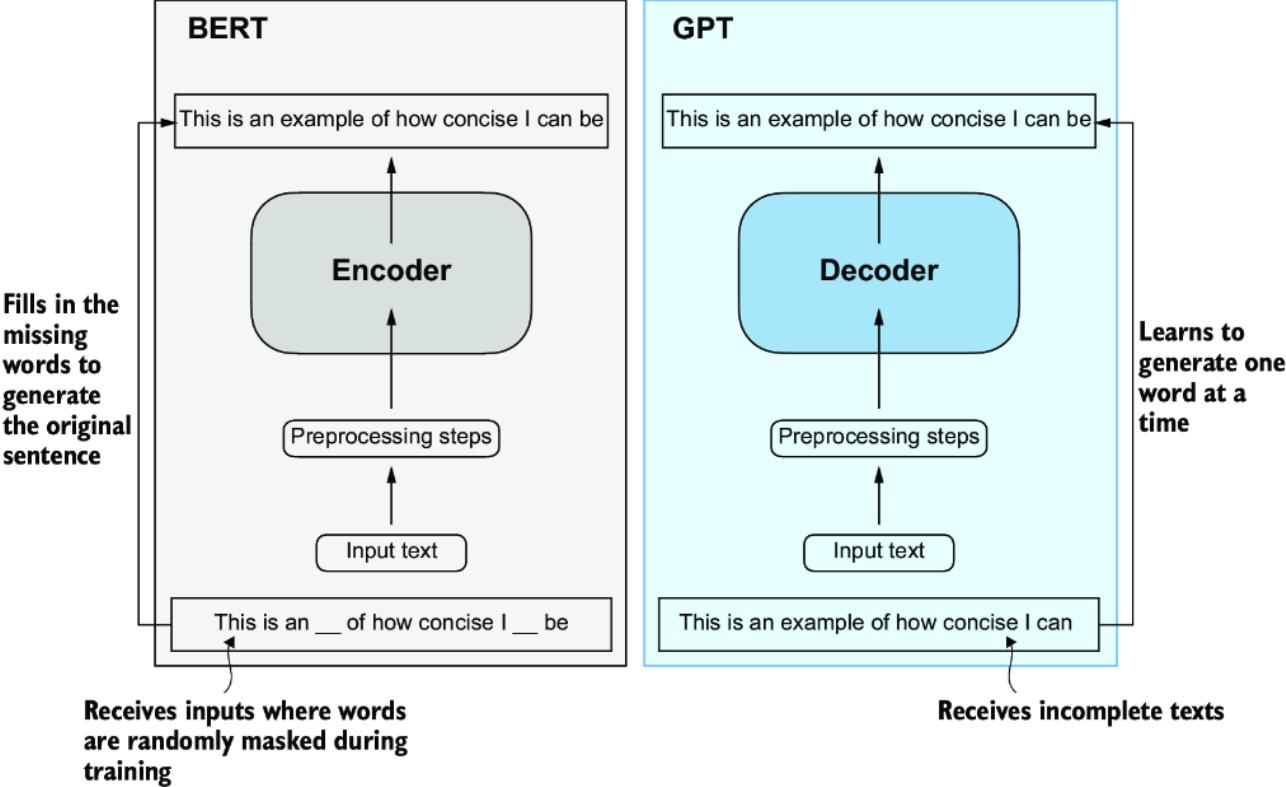

In [67]:
response = chain_with_sources.invoke(
    "What is architecture of transformer ?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)